### Multi-Class Model for Kaggle Tabular Playground Series May 2021 Using TensorFlow Decision Forests
### David Lowe
### November 12, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground May 2021 dataset is a multi-class modeling situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The dataset used for this competition is synthetic but based on a real dataset and generated using a CTGAN. The original dataset deals with predicting the category on an eCommerce product given various attributes about the listing. Although the features are anonymized, they have properties relating to real-world features.

ANALYSIS: The average performance of the three decision forests algorithms achieved a logarithmic loss benchmark of 1.6657 using the validation dataset. After a series of tuning trials, the refined Gradient Boosted Trees model processed the training dataset with a final logarithmic loss score of 1.3096. When we processed Kaggle's test dataset with the final model, the model achieved a logarithmic loss score of 2.1399.

CONCLUSION: In this iteration, the TensorFlow Decision Forests model did not appear to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground 2021 May Data Set

Dataset ML Model: Multi-Class classification with categorical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-may-2021/

One potential source of performance benchmark: https://www.kaggle.com/c/tabular-playground-series-may-2021/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Train and Evaluate Models
4. Fine-tune and Improve Models
5. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL
!pip install tensorflow_decision_forests

In [2]:
!pip install wurlitzer

In [3]:
# Retrieve the GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [4]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [5]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [7]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
import tensorflow_decision_forests as tfdf

In [8]:
try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

### 1.b) Set up the controlling parameters and functions

In [9]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.1

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_METRICS = ["accuracy", tf.keras.metrics.SparseCategoricalCrossentropy()]

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Num GPUs Available: 0
TensorFlow version: 2.6.0
Found TensorFlow Decision Forests v0.2.0


In [10]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [11]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [12]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [13]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021may/train.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id  feature_0  feature_1  ...  feature_48  feature_49   target
0   0          0          0  ...           0           0  Class_2
1   1          0          0  ...           0           0  Class_1
2   2          0          0  ...           2           0  Class_1
3   3          0          0  ...           1           0  Class_4
4   4          0          0  ...           1           0  Class_2

[5 rows x 52 columns]


In [14]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          100000 non-null  int64 
 1   feature_0   100000 non-null  int64 
 2   feature_1   100000 non-null  int64 
 3   feature_2   100000 non-null  int64 
 4   feature_3   100000 non-null  int64 
 5   feature_4   100000 non-null  int64 
 6   feature_5   100000 non-null  int64 
 7   feature_6   100000 non-null  int64 
 8   feature_7   100000 non-null  int64 
 9   feature_8   100000 non-null  int64 
 10  feature_9   100000 non-null  int64 
 11  feature_10  100000 non-null  int64 
 12  feature_11  100000 non-null  int64 
 13  feature_12  100000 non-null  int64 
 14  feature_13  100000 non-null  int64 
 15  feature_14  100000 non-null  int64 
 16  feature_15  100000 non-null  int64 
 17  feature_16  100000 non-null  int64 
 18  feature_17  100000 non-null  int64 
 19  feature_18  100000 non-n

In [15]:
print(df_dataset_import.describe())

                  id      feature_0  ...     feature_48    feature_49
count  100000.000000  100000.000000  ...  100000.000000  100000.00000
mean    49999.500000       0.257830  ...       0.970850       0.55712
std     28867.657797       0.929033  ...       2.576615       1.68093
min         0.000000       0.000000  ...       0.000000       0.00000
25%     24999.750000       0.000000  ...       0.000000       0.00000
50%     49999.500000       0.000000  ...       0.000000       0.00000
75%     74999.250000       0.000000  ...       1.000000       0.00000
max     99999.000000      10.000000  ...      44.000000      20.00000

[8 rows x 51 columns]


In [16]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id            0
feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
feature_28    0
feature_29    0
feature_30    0
feature_31    0
feature_32    0
feature_33    0
feature_34    0
feature_35    0
feature_36    0
feature_37    0
feature_38    0
feature_39    0
feature_40    0
feature_41    0
feature_42    0
feature_43    0
feature_44    0
feature_45    0
feature_46    0
feature_47    0
feature_48    0
feature_49    0
target        0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [17]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Standardize the class column to the name of target
df_dataset_import = df_dataset_import.rename(columns={'claim':'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

   feature_0  feature_1  feature_2  ...  feature_48  feature_49   target
0          0          0          1  ...           0           0  Class_2
1          0          0          0  ...           0           0  Class_1
2          0          0          0  ...           2           0  Class_1
3          0          0          0  ...           1           0  Class_4
4          0          0          0  ...           1           0  Class_2

[5 rows x 51 columns]


In [18]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 51 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   feature_0   100000 non-null  int64 
 1   feature_1   100000 non-null  int64 
 2   feature_2   100000 non-null  int64 
 3   feature_3   100000 non-null  int64 
 4   feature_4   100000 non-null  int64 
 5   feature_5   100000 non-null  int64 
 6   feature_6   100000 non-null  int64 
 7   feature_7   100000 non-null  int64 
 8   feature_8   100000 non-null  int64 
 9   feature_9   100000 non-null  int64 
 10  feature_10  100000 non-null  int64 
 11  feature_11  100000 non-null  int64 
 12  feature_12  100000 non-null  int64 
 13  feature_13  100000 non-null  int64 
 14  feature_14  100000 non-null  int64 
 15  feature_15  100000 non-null  int64 
 16  feature_16  100000 non-null  int64 
 17  feature_17  100000 non-null  int64 
 18  feature_18  100000 non-null  int64 
 19  feature_19  100000 non-n

In [19]:
print(df_dataset_import.describe())

           feature_0      feature_1  ...     feature_48    feature_49
count  100000.000000  100000.000000  ...  100000.000000  100000.00000
mean        0.257830       0.431720  ...       0.970850       0.55712
std         0.929033       1.977862  ...       2.576615       1.68093
min         0.000000       0.000000  ...       0.000000       0.00000
25%         0.000000       0.000000  ...       0.000000       0.00000
50%         0.000000       0.000000  ...       0.000000       0.00000
75%         0.000000       0.000000  ...       1.000000       0.00000
max        10.000000      31.000000  ...      44.000000      20.00000

[8 rows x 50 columns]


In [20]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
feature_28    0
feature_29    0
feature_30    0
feature_31    0
feature_32    0
feature_33    0
feature_34    0
feature_35    0
feature_36    0
feature_37    0
feature_38    0
feature_39    0
feature_40    0
feature_41    0
feature_42    0
feature_43    0
feature_44    0
feature_45    0
feature_46    0
feature_47    0
feature_48    0
feature_49    0
target        0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [21]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (100000, 51) df_features_train.shape: (100000, 50) df_target_train.shape: (100000,)


### 1.f) Set up the parameters for data visualization

In [22]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [23]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [24]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

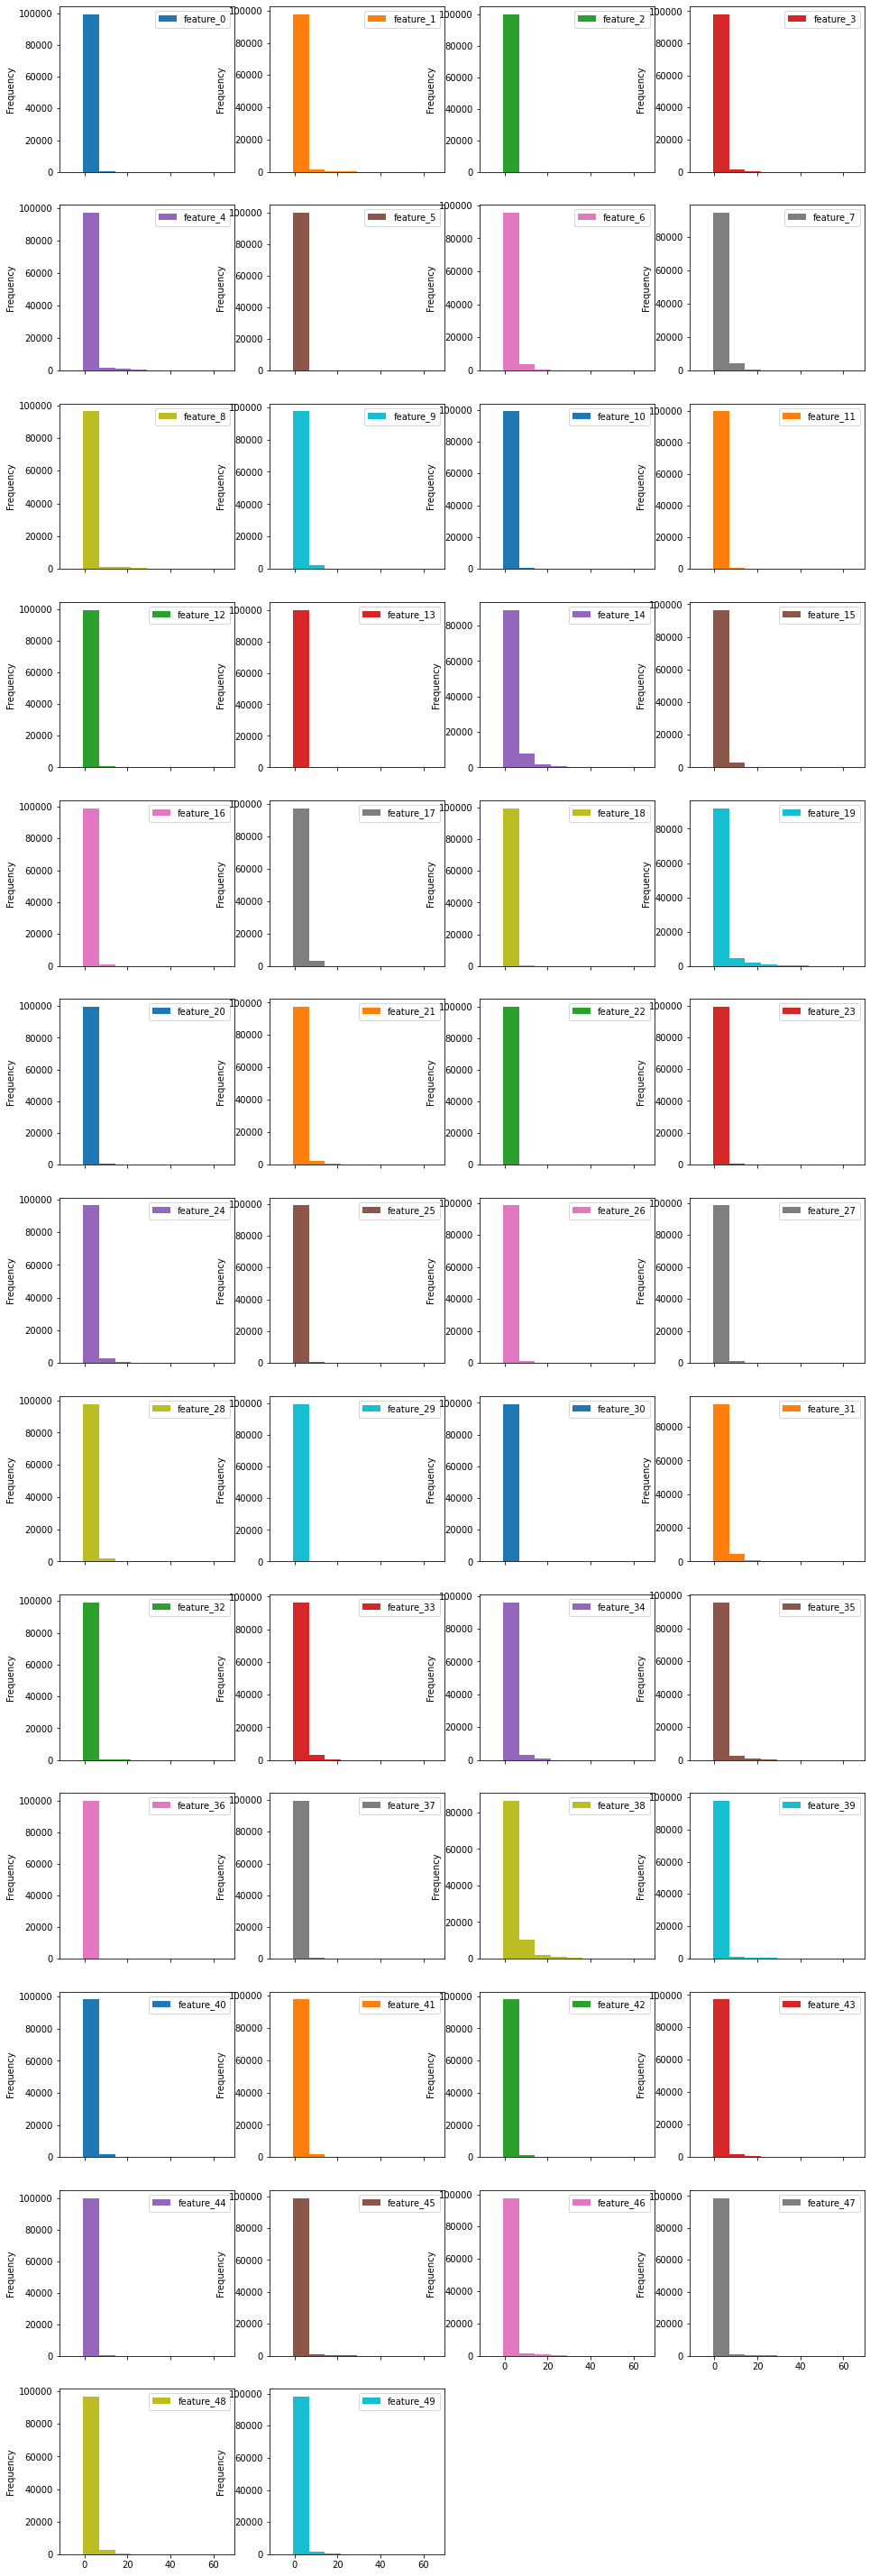

In [25]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

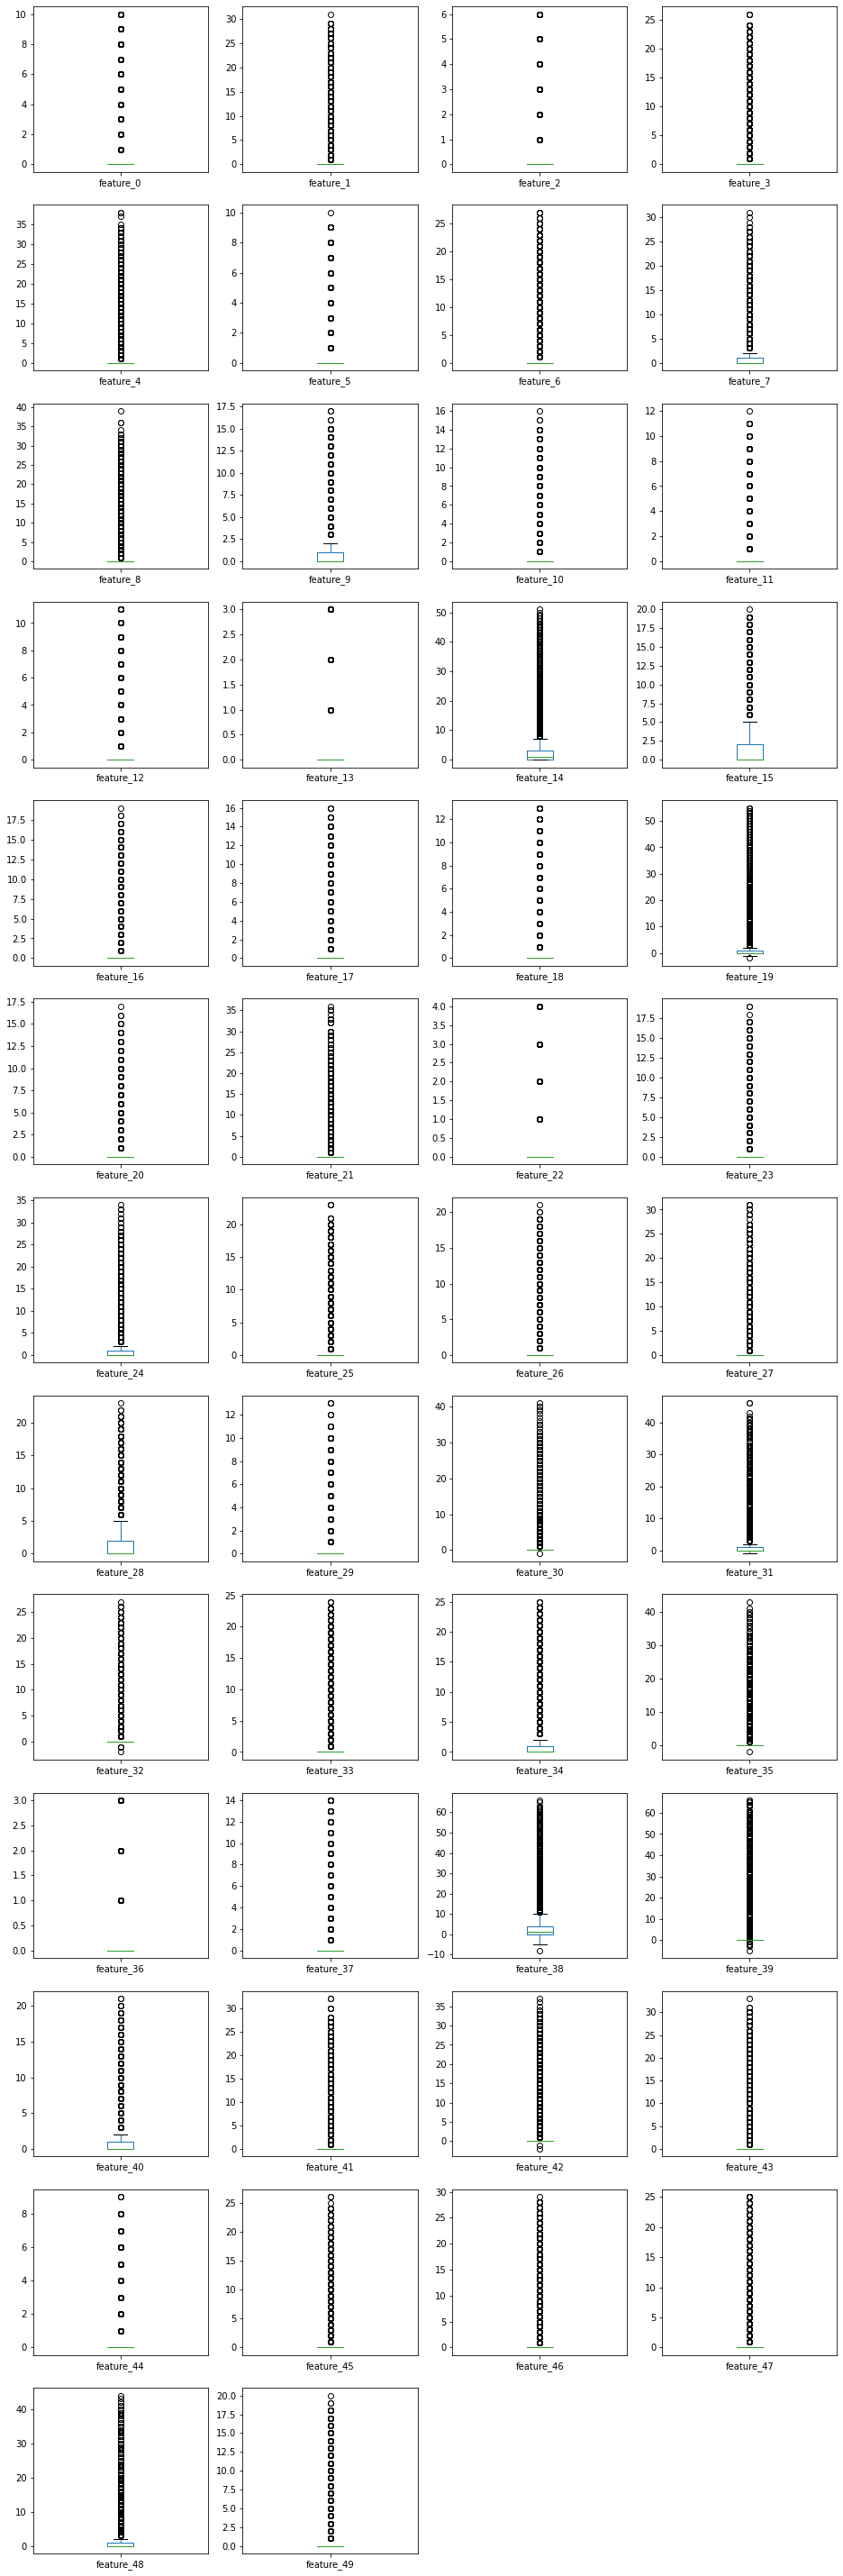

In [26]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

In [27]:
# # Correlation matrix
# fig = plt.figure(figsize=(20, 20))
# correlations = df_features_train.corr(method='pearson')
# sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
# plt.show()

In [28]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Train and Evaluate Models

In [29]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Validation Sets

In [30]:
# Encode the categorical label into an integer.
label = "target"

classes = df_dataset_import[label].unique().tolist()
print(f"Label classes: {classes}")

df_dataset_import[label] = df_dataset_import[label].map(classes.index)

Label classes: ['Class_2', 'Class_1', 'Class_4', 'Class_3']


In [31]:
# Split the data further into training and validation datasets
df_dataset_train, df_dataset_valid = train_test_split(df_dataset_import, test_size=VAL_SET_RATIO, random_state=RNG_SEED)
print("df_dataset_train.shape: {} df_dataset_valid.shape: {}".format(df_dataset_train.shape, df_dataset_valid.shape))

df_dataset_train.shape: (90000, 51) df_dataset_valid.shape: (10000, 51)


In [32]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_train, label='target')
tfds_valid = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_valid, label='target')

### 3.b) Train and Evaluate the Random Forest Model

In [33]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
model_1 = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
model_1.compile(metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_1.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

2021-11-07 19:15:53.234545: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1407/1407 [==============================] - 13s 5ms/step


[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 1407
[INFO kernel.cc:393] Number of examples: 90000
[INFO kernel.cc:759] Dataset:
Number of records: 90000
Number of columns: 51

Number of columns by type:
	NUMERICAL: 50 (98.0392%)
	CATEGORICAL: 1 (1.96078%)

Columns:

NUMERICAL: 50 (98.0392%)
	0: "feature_0" NUMERICAL mean:0.257467 min:0 max:10 sd:0.926727
	1: "feature_1" NUMERICAL mean:0.430422 min:0 max:31 sd:1.97682
	2: "feature_10" NUMERICAL mean:0.313089 min:0 max:15 sd:1.12138
	3: "feature_11" NUMERICAL mean:0.405011 min:0 max:12 sd:1.015
	4: "feature_12" NUMERICAL mean:0.461733 min:0 max:11 sd:1.12911
	5: "feature_13" NUMERICAL mean:0.0758667 min:0 max:3 sd:0.359814
	6: "feature_14" NUMERICAL mean:2.60303 min:0 max:51 sd:4.66404
	7: "feature_15" NUMERICAL mean:1.24094 min:0 max:20 sd:2.16212
	8: "feature_16" NUMERICAL mean:0.3671 min:0 max:19 sd:1.28904
	9: "feature_17" NUMERICAL mean:0.73

Model training time: 0:02:30.824181 



In [34]:
tfdf.model_plotter.plot_model_in_colab(model_1)

In [35]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=90000, accuracy=0.5756222222222223, loss=5.9654863316973055, rmse=None, ndcg=None, aucs=None)

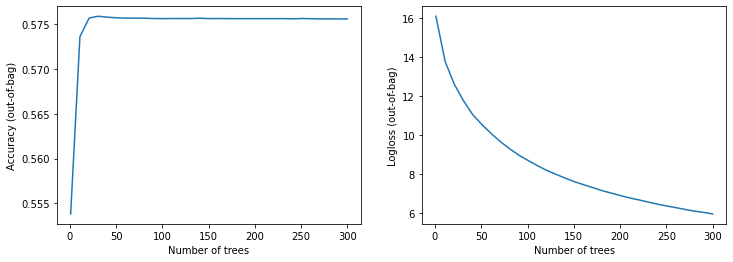

In [36]:
logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [37]:
evaluation = model_1.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

157/157 [==============================] - 2s 11ms/step - loss: 0.0000e+00 - accuracy: 0.5692 - sparse_categorical_crossentropy: 2.7166

loss: 0.0000
accuracy: 0.5692
sparse_categorical_crossentropy: 2.7166


### 3.c) Train and Evaluate the Decision Trees Model

In [38]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
model_2 = tfdf.keras.CartModel(task = tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
model_2.compile(
    metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_2.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

1407/1407 [==============================] - 7s 5ms/step


[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 1407
[INFO kernel.cc:393] Number of examples: 90000
[INFO kernel.cc:759] Dataset:
Number of records: 90000
Number of columns: 51

Number of columns by type:
	NUMERICAL: 50 (98.0392%)
	CATEGORICAL: 1 (1.96078%)

Columns:

NUMERICAL: 50 (98.0392%)
	0: "feature_0" NUMERICAL mean:0.257467 min:0 max:10 sd:0.926727
	1: "feature_1" NUMERICAL mean:0.430422 min:0 max:31 sd:1.97682
	2: "feature_10" NUMERICAL mean:0.313089 min:0 max:15 sd:1.12138
	3: "feature_11" NUMERICAL mean:0.405011 min:0 max:12 sd:1.015
	4: "feature_12" NUMERICAL mean:0.461733 min:0 max:11 sd:1.12911
	5: "feature_13" NUMERICAL mean:0.0758667 min:0 max:3 sd:0.359814
	6: "feature_14" NUMERICAL mean:2.60303 min:0 max:51 sd:4.66404
	7: "feature_15" NUMERICAL mean:1.24094 min:0 max:20 sd:2.16212
	8: "feature_16" NUMERICAL mean:0.3671 min:0 max:19 sd:1.28904
	9: "feature_17" NUMERICAL mean:0.73

Model training time: 0:00:11.569938 



In [39]:
tfdf.model_plotter.plot_model_in_colab(model_2)

In [40]:
evaluation = model_2.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

157/157 [==============================] - 2s 6ms/step - loss: 0.0000e+00 - accuracy: 0.5639 - sparse_categorical_crossentropy: 1.9459

loss: 0.0000
accuracy: 0.5639
sparse_categorical_crossentropy: 1.9459


### 3.d) Train and Evaluate the Gradient Boosted Trees Model

In [41]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
model_3 = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
model_3.compile(
    metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_3.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

1407/1407 [==============================] - 7s 5ms/step


[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 1407
[INFO kernel.cc:393] Number of examples: 90000
[INFO kernel.cc:759] Dataset:
Number of records: 90000
Number of columns: 51

Number of columns by type:
	NUMERICAL: 50 (98.0392%)
	CATEGORICAL: 1 (1.96078%)

Columns:

NUMERICAL: 50 (98.0392%)
	0: "feature_0" NUMERICAL mean:0.257467 min:0 max:10 sd:0.926727
	1: "feature_1" NUMERICAL mean:0.430422 min:0 max:31 sd:1.97682
	2: "feature_10" NUMERICAL mean:0.313089 min:0 max:15 sd:1.12138
	3: "feature_11" NUMERICAL mean:0.405011 min:0 max:12 sd:1.015
	4: "feature_12" NUMERICAL mean:0.461733 min:0 max:11 sd:1.12911
	5: "feature_13" NUMERICAL mean:0.0758667 min:0 max:3 sd:0.359814
	6: "feature_14" NUMERICAL mean:2.60303 min:0 max:51 sd:4.66404
	7: "feature_15" NUMERICAL mean:1.24094 min:0 max:20 sd:2.16212
	8: "feature_16" NUMERICAL mean:0.3671 min:0 max:19 sd:1.28904
	9: "feature_17" NUMERICAL mean:0.73

Model training time: 0:02:23.309173 



In [42]:
tfdf.model_plotter.plot_model_in_colab(model_3)

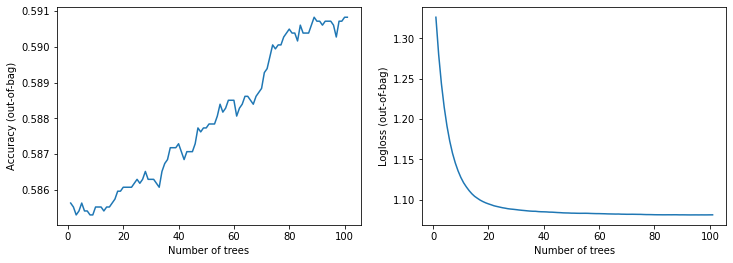

In [43]:
logs = model_3.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [44]:
evaluation = model_3.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

157/157 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 0.5723 - sparse_categorical_crossentropy: 1.6657

loss: 0.0000
accuracy: 0.5723
sparse_categorical_crossentropy: 1.6657


In [45]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Fine-tune and Improve Models

In [46]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [47]:
for num_trees in [300, 500, 750, 1000]:
    # Define the baseline model for benchmarking
    start_time_module = datetime.now()
    reset_random()
    model_tune = tfdf.keras.GradientBoostedTreesModel(num_trees=num_trees)

    # Optionally, add evaluation metrics.
    model_tune.compile(metrics=DEFAULT_METRICS)

    # Train the model.
    model_tune.fit(x=tfds_train, verbose=False)

    evaluation = model_tune.evaluate(tfds_valid, return_dict=True)
    print()

    for name, value in evaluation.items():
        print(f"{name}: {value:.4f}")
    print ('Model optimization time:', (datetime.now() - start_time_module), '\n')

157/157 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 0.5723 - sparse_categorical_crossentropy: 1.5256

loss: 0.0000
accuracy: 0.5723
sparse_categorical_crossentropy: 1.5256
Model optimization time: 0:01:58.417335 



157/157 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 0.5723 - sparse_categorical_crossentropy: 1.4415

loss: 0.0000
accuracy: 0.5723
sparse_categorical_crossentropy: 1.4415
Model optimization time: 0:01:58.536746 



157/157 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 0.5723 - sparse_categorical_crossentropy: 1.3855

loss: 0.0000
accuracy: 0.5723
sparse_categorical_crossentropy: 1.3855
Model optimization time: 0:01:58.809698 

157/157 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 0.5723 - sparse_categorical_crossentropy: 1.3454

loss: 0.0000
accuracy: 0.5723
sparse_categorical_crossentropy: 1.3454
Model optimization time: 0:01:58.583644 



In [48]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [49]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [50]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_import, label='target')

In [51]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
final_model = tfdf.keras.GradientBoostedTreesModel(num_trees=1000)

# Optionally, add evaluation metrics.
final_model.compile(
    metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    final_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

1563/1563 [==============================] - 9s 5ms/step


[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 1563
[INFO kernel.cc:393] Number of examples: 100000
[INFO kernel.cc:759] Dataset:
Number of records: 100000
Number of columns: 51

Number of columns by type:
	NUMERICAL: 50 (98.0392%)
	CATEGORICAL: 1 (1.96078%)

Columns:

NUMERICAL: 50 (98.0392%)
	0: "feature_0" NUMERICAL mean:0.25783 min:0 max:10 sd:0.929028
	1: "feature_1" NUMERICAL mean:0.43172 min:0 max:31 sd:1.97785
	2: "feature_10" NUMERICAL mean:0.31368 min:0 max:16 sd:1.12116
	3: "feature_11" NUMERICAL mean:0.40375 min:0 max:12 sd:1.01141
	4: "feature_12" NUMERICAL mean:0.46147 min:0 max:11 sd:1.12872
	5: "feature_13" NUMERICAL mean:0.07565 min:0 max:3 sd:0.359008
	6: "feature_14" NUMERICAL mean:2.59732 min:0 max:51 sd:4.65507
	7: "feature_15" NUMERICAL mean:1.24203 min:0 max:20 sd:2.1601
	8: "feature_16" NUMERICAL mean:0.36483 min:0 max:19 sd:1.28415
	9: "feature_17" NUMERICAL mean:0.74 mi

Model training time: 0:02:39.164369 



In [52]:
final_model.summary()

Model: "gradient_boosted_trees_model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (50):
	feature_0
	feature_1
	feature_10
	feature_11
	feature_12
	feature_13
	feature_14
	feature_15
	feature_16
	feature_17
	feature_18
	feature_19
	feature_2
	feature_20
	feature_21
	feature_22
	feature_23
	feature_24
	feature_25
	feature_26
	feature_27
	feature_28
	feature_29
	feature_3
	feature_30
	feature_31
	feature_32
	feature_33
	feature_34
	feature_35
	feature_36
	feature_37
	feature_38
	feature_39
	feature_4
	feature_40
	feature_41
	feature_42
	feature_43
	feature_44
	feature_45
	feature_46
	feature_47
	feature_48
	feature_49
	feature_5
	feature_6
	feature_7
	feature_8
	feature_9

No weights

Variable

In [53]:
tfdf.model_plotter.plot_model_in_colab(final_model)

In [54]:
evaluation = final_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

157/157 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.5833 - sparse_categorical_crossentropy: 1.3096

loss: 0.0000
accuracy: 0.5833
sparse_categorical_crossentropy: 1.3096


### 5.b) Load Test Dataset and Prepare the Submission File

In [55]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021may/test.csv'
df_features_test = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

       id  feature_0  feature_1  ...  feature_47  feature_48  feature_49
0  100000          0          0  ...           0           0           0
1  100001          0          0  ...           0           2           1
2  100002          0          0  ...           0           6           0
3  100003          0          0  ...           9          14           3
4  100004          0          0  ...           0           0           0

[5 rows x 51 columns]


In [56]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

       id
0  100000
1  100001
2  100002
3  100003
4  100004


In [57]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

   feature_0  feature_1  feature_2  ...  feature_47  feature_48  feature_49
0          0          0          0  ...           0           0           0
1          0          0          1  ...           0           2           1
2          0          0          0  ...           0           6           0
3          0          0          0  ...           9          14           3
4          0          0          0  ...           0           0           0

[5 rows x 50 columns]


In [58]:
# Finalize the test dataset for the prediction activities
tfds_test = tfdf.keras.pd_dataframe_to_tf_dataset(df_features_test)

In [59]:
# Make batched predictions
test_predictions = final_model.predict(tfds_test)
print(test_predictions)

[[0.58314735 0.1010782  0.12285884 0.19291566]
 [0.69197416 0.0722032  0.09024925 0.14557336]
 [0.6351759  0.09549578 0.09873607 0.17059231]
 ...
 [0.52002776 0.10650472 0.15762937 0.21583804]
 [0.5905927  0.08520122 0.1533998  0.17080621]
 [0.5866085  0.09068009 0.12932953 0.19338183]]


In [60]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021may/sample_submission.csv'
df_sample_submission = pd.read_csv(dataset_path, index_col=False)
df_sample_submission.drop(columns=['id'], inplace=True)
submission_header = list(df_sample_submission.columns)
print(submission_header)

['Class_1', 'Class_2', 'Class_3', 'Class_4']


In [61]:
df_kaggle_submission[submission_header] = test_predictions
print(df_kaggle_submission.head())

       id   Class_1   Class_2   Class_3   Class_4
0  100000  0.583147  0.101078  0.122859  0.192916
1  100001  0.691974  0.072203  0.090249  0.145573
2  100002  0.635176  0.095496  0.098736  0.170592
3  100003  0.584582  0.084538  0.078255  0.252626
4  100004  0.628432  0.073062  0.097010  0.201496


In [62]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20211107-1931.csv


In [63]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [64]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:16:20.592453
